In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc
import numpy.random as rn
import networkx as nx
import my_networkx as my_nx
import frame as frame
from numba import jit, njit, prange
import scipy.linalg as la


mpl.rcParams.update({'font.size': 25})

In [2]:
# size of network
N = 6

# adjacency matrix
A = np.array([[0, 1, 0, 1, 1, 0], [1, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1], [0, 1, 0, 0, 1, 0]])
frame.printMatrix(A)

0.00   1.00   0.00   1.00   1.00   0.00   

1.00   0.00   1.00   0.00   0.00   1.00   

0.00   1.00   0.00   0.00   0.00   0.00   

1.00   0.00   0.00   0.00   0.00   0.00   

1.00   0.00   0.00   0.00   0.00   1.00   

0.00   1.00   0.00   0.00   1.00   0.00   



In [3]:
# master operator, values from Rick in SuppMat
L = np.zeros((N, N))
# fill with values
L[0, 1] = 5.997
L[1, 0] = 0.774

L[0, 3] = 13.439
L[3, 0] = 127.968

L[0, 4] = 15.330
L[4, 0] = 0.121

L[4, 5] = 3.749
L[5, 4] = 13.326

L[1, 2] = 1514.820
L[2, 1] = 53.0661

L[1, 5] = 13.441
L[5, 1] = 2.922

L = L.T

#diagonal elements
for i in range(N):
    L[i,i] = -np.sum(L[:, i])


frame.printMatrix(L)

-34.77   0.77   0.00   127.97   0.12   0.00   

6.00   -1529.03   53.07   0.00   0.00   2.92   

0.00   1514.82   -53.07   0.00   0.00   0.00   

13.44   0.00   0.00   -127.97   0.00   0.00   

15.33   0.00   0.00   0.00   -3.87   13.33   

0.00   13.44   0.00   0.00   3.75   -16.25   



In [4]:
# find eigenvalues and eigenvectors
ew, ev = sc.linalg.eig(L)
print(ew)
# frame.printMatrix(ev)

# relevant eigenvector has eigenvalue 0
peq = ev[:, 4]
# print(peq)

# need to "normalise" it such that sum of entries is 1

Z = np.sum(peq)
# print(Z)
peq = peq / Z

print(np.sum(peq))

print(peq)

print(np.sort(np.abs(ew)))

[-1.58165132e+03+0.j -1.43749631e+02+0.j -1.98531625e+01+0.j
 -1.86991129e+01+0.j  1.53222889e-13+0.j -9.99871767e-01+0.j]
1.0
[2.54859615e-03 1.97475509e-02 5.63711767e-01 2.67649597e-04
 3.22886823e-01 9.08376128e-02]
[1.53222889e-13 9.99871767e-01 1.86991129e+01 1.98531625e+01
 1.43749631e+02 1.58165132e+03]


In [5]:
# check for DB
for i in range(N):
    for j in range(N):
        if A[i, j] == 1:
            print("%.5f \t %.5f \t %.5f" % (L[i, j]*peq[j], L[j, i]*peq[i], L[j, i]*peq[i] / (L[i, j]*peq[j])))

0.01528 	 0.01528 	 0.99996
0.03425 	 0.03425 	 1.00000
0.03907 	 0.03907 	 1.00002
0.01528 	 0.01528 	 1.00004
29.91399 	 29.91399 	 1.00000
0.26543 	 0.26543 	 1.00000
29.91399 	 29.91399 	 1.00000
0.03425 	 0.03425 	 1.00000
0.03907 	 0.03907 	 0.99998
1.21050 	 1.21050 	 1.00000
0.26543 	 0.26543 	 1.00000
1.21050 	 1.21050 	 1.00000


In [6]:
# initial distribution
initial_p = np.array([0, 0, 0, 0, 0, 1])

# initialise class
system = frame.JumpProcessMasterEquation(N, initial_p, L, 100)

In [30]:
@jit
def master_eq_evolution(t:float, L: np.ndarray, initial_dist):
        
        propagator = la.expm(L * t)

        return np.matmul(propagator, initial_dist)

def initial_state(initial_p, states):
    """Function to randomly determine initial condition given a initial distribution

    Returns:
        int: (random) initial state
    """
    n_0 = rn.choice(states, 1, p=initial_p)

    return n_0[0]

@njit
def Trajectory_sample(init_state: int, final_time: float, L: np.ndarray):
    
    # list with states in it
    trajectory = [init_state]
    I = init_state
    # list of transition times to the next respective states
    state_time = []

    Gamma = -np.diag(L)

    N = len(L)
    # print(transition_matrix[trajectory[-1]-1, trajectory[-1]-1])
    # start at time 0
    tau = 0
    while tau <= final_time:
        # draw the escape time according to an exponential distribution
        # note that the index for states starts at 1, hence we have to subtract to get the appropriate index
        r1, r2 = np.random.uniform(0,1, 2)

        temp = 0

        for J in range(N):
            if J == I:
                p_ij = 0
            else:
                p_ij = L[J][I] / (-L[I][I])
            
            temp += p_ij

            if temp >= r2:
                tau += -np.log(r1) / Gamma[I]
                I = J
                trajectory.append(I)
                state_time.append(tau)
                break
            else:
                continue

    return np.asarray(trajectory), np.asarray(state_time)

@jit
def analytic_solution(d_matrix, L, final_time, number_times, Adj, initial_p):
    
    dt = final_time / number_times

    avg_J = 0
    var_J = 0
    S = 0

    for m in range(1, number_times):
        p_an = master_eq_evolution(m*dt, L, initial_p)
        
        for i in range(len(p_an)):
            for j in range(len(p_an)):
                if i != j:
                    avg_J += dt * p_an[i] * d_matrix[i, j] * L[j, i]
                    var_J += dt * p_an[i] * d_matrix[i, j]**2 * L[j, i]
                    if Adj[i, j] == 1:
                        S += dt * p_an[i] *  L[j, i] * np.log((p_an[i] *  L[j, i]) / (p_an[j] *  L[i, j]))

    return avg_J, var_J - avg_J**2, S



@njit(parallel=True)
def current_sample(n_sample:int, time: np.ndarray, init_state:int, L:np.ndarray, d: np.ndarray):
    tmax = time[-1]
    dt = time[1] - time[0] # assume all dt are the same
    nt = len(time)

    J = np.zeros((n_sample, nt-1))

    # n_sample amout of samples
    for i in prange(n_sample):
        traj, t_time = Trajectory_sample(init_state, tmax, L)
        for t in prange(1, nt):
            index = np.where(t_time <= time[t])[0]
            for j in index:
                J[i, t-1] += d[traj[j], traj[j+1]]

    J_mean = np.zeros(nt-1)
    J_var = np.zeros(nt-1)

    # calculate mean and variance
    for t in prange(1, nt):
        J_mean[t-1] = np.mean(J[:, t-1])
        J_var[t-1] = np.var(J[:, t-1])
    print("############# SAMPLE DONE ################")

            
    return J_mean, J_var

def analytic_time(d, L, time, A, initial_p, n_time):
    nt = len(time)
    an_mean = np.zeros(nt-1)
    an_var = np.zeros(nt-1)
    an_S = np.zeros(nt-1)
    N = len(initial_p)
    for t in prange(1, nt):
        dt = time[t] / n_time
        propagator = la.expm(L * dt)
        p = initial_p
        for k in prange(n_time):
            print(t, k)

            p = np.matmul(propagator, p)
            for i in prange(N):
                for j in prange(N):
                    if i != j:
                        an_mean[t-1] += dt * p[i] * d_matrix[i, j] * L[j, i]
                        an_var[t-1] += dt * p[i] * d_matrix[i, j]**2 * L[j, i]
                        if A[i, j] == 1:
                            an_S[t-1] += dt * p[i] *  L[j, i] * np.log((p[i] *  L[j, i]) / (p[j] *  L[i, j]))
                        
                        # need the complicated correlation term
                        # second time integral, goes up to value of first integral
                        dummy2 = 0
                        for ti in prange(k+1):
                            p_m = np.matmul(la.expm(L * ti*dt), initial_p)
                            pro = la.expm(L * (k-ti)*dt)
                            # state sums
                            # n = y, m = x
                            for m in prange(N):
                                prob_m = p_m[m]
                                for n in prange(N):                                        
                                    dummy2 += d[m,n] * L[n, m] * prob_m * pro[i, n]
                        
                        an_var[t-1] += 2*dummy2 * d[i, j] * L[j, i] * dt ** 2
                    





    return an_mean, an_var - an_mean**2, an_S


A = np.array([[0, 1, 0, 1, 1, 0], [1, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1], [0, 1, 0, 0, 1, 0]])

d_matrix = np.array([[0, 1, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])


initial_p = np.array([0, 0, 0, 0, 0, 1])
states = np.arange(0, 6)

init_state = initial_state(initial_p, states)

time = np.linspace(0, 5, 200)
# print(analytic_solution(d_matrix, L, 10, 1000, A, initial_p))






In [31]:

t1 = np.linspace(0, 5, 20)
an_mean, an_var, an_S = analytic_time(d_matrix, L, t1, A, initial_p, 200)


1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
1 100
1 101
1 102
1 103
1 104
1 105
1 106
1 107
1 108
1 109
1 110
1 111
1 112
1 113
1 114
1 115
1 116
1 117
1 118
1 119
1 120
1 121
1 122
1 123
1 124
1 125
1 126
1 127
1 128
1 129
1 130
1 131
1 132
1 133
1 134
1 135
1 136
1 137
1 138
1 139
1 140
1 141
1 142
1 143
1 144
1 145
1 146
1 147
1 148
1 149
1 150
1 151
1 152
1 153
1 154
1 155
1 156
1 157
1 158
1 159
1 160
1 161
1 162
1 163
1 164
1 165
1 166
1 167
1 168
1 169
1 170
1 171
1 172
1 173
1 174
1 175
1 176
1 177
1 178
1 179
1 180
1 181
1 182
1 183
1 184


In [33]:
mean, var = current_sample(5000000, np.linspace(0, 5, 200), init_state, L, d_matrix)


: 

: 

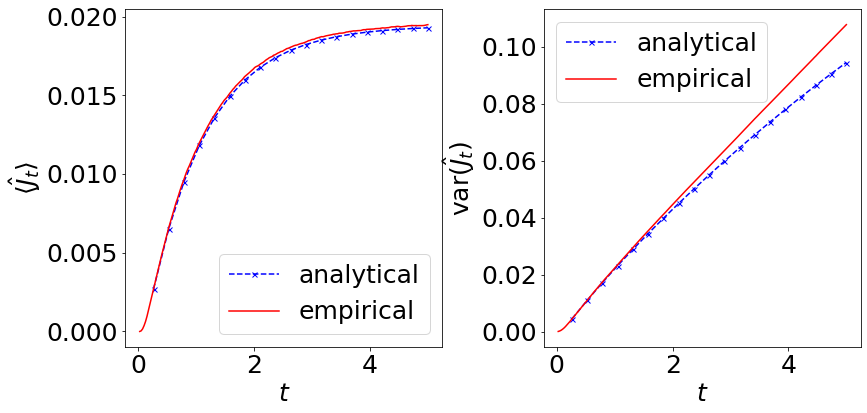

In [ ]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

plt.tight_layout()

ax[0].plot(t1[1:], an_mean, "b--x", label="analytical", ms=5)
ax[0].plot(time[1:], mean, "r-", label="empirical")

ax[1].plot(t1[1:], an_var, "b--x", label="analytical", ms=5)
ax[1].plot(time[1:], var, "r-", label="empirical")


ax[0].set_ylabel(r"$\langle \hat{J}_t\rangle$")
ax[0].set_xlabel(r"$t$")
ax[1].set_ylabel(r"var$(\hat{J}_t)$")
ax[1].set_xlabel(r"$t$")
ax[0].legend()
ax[1].legend()

In [9]:
print(np.shape(traj[0]), np.shape(traj[1]))

(257,) (258,)


In [10]:
p, t = system.empirical_probability(5, trajectories, trajectory_times)
p = np.array(p)


In [11]:
analytic = []

for k in t:
    analytic.append(system.master_eq_evolution(k))

analytic = np.array(analytic)

In [12]:
print(np.shape(analytic), np.shape(p), np.shape(t))
print(p[:, 1])

(100, 6) (100, 6) (100,)
[0.      0.00444 0.00536 0.00679 0.00721 0.00785 0.00909 0.00889 0.00946
 0.01047 0.01033 0.01116 0.01086 0.01177 0.01229 0.01243 0.01332 0.01307
 0.01279 0.01353 0.01479 0.01374 0.01427 0.01491 0.01515 0.01522 0.01477
 0.01588 0.01595 0.01645 0.01652 0.0154  0.01719 0.01682 0.0176  0.01701
 0.01756 0.01693 0.01723 0.01747 0.01819 0.01749 0.0185  0.01818 0.01732
 0.01722 0.01871 0.01811 0.01832 0.01831 0.01809 0.01784 0.01825 0.01827
 0.01841 0.019   0.01908 0.01858 0.0185  0.0191  0.01925 0.01833 0.01909
 0.01903 0.01944 0.01917 0.01979 0.01871 0.01936 0.01894 0.01875 0.01888
 0.01968 0.01874 0.01906 0.01926 0.01985 0.01965 0.01965 0.01966 0.01967
 0.01951 0.0196  0.01944 0.01991 0.01989 0.01904 0.01976 0.01924 0.02009
 0.02018 0.01961 0.01949 0.02013 0.01984 0.0202  0.01964 0.02004 0.02019
 0.01932]


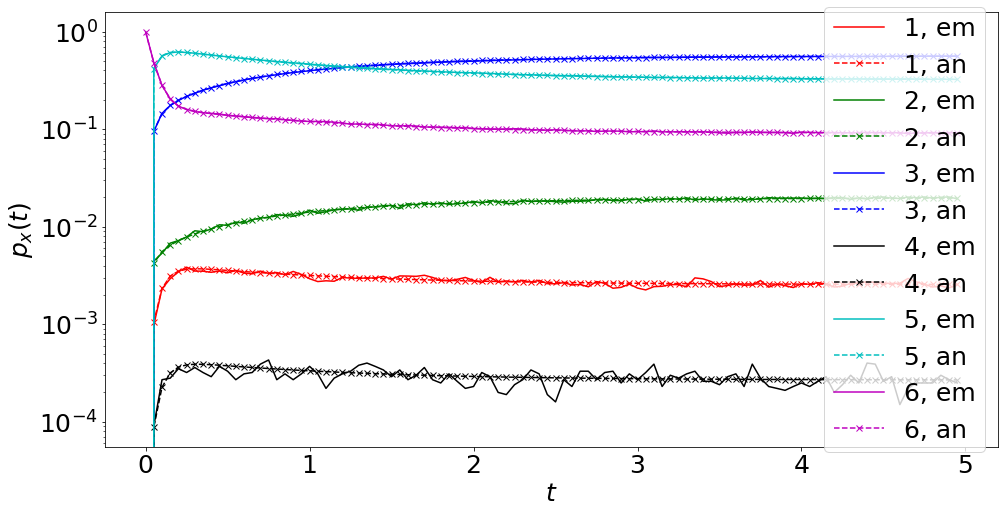

In [13]:
fig = plt.figure(figsize=(16, 8))

plt.plot(t, p[:, 0], "r-", label="1, em")
plt.plot(t, analytic[:, 0], "r--x", label="1, an")


plt.plot(t, p[:, 1], "g-", label="2, em")
plt.plot(t, analytic[:, 1], "g--x", label="2, an")


plt.plot(t, p[:, 2], "b-", label="3, em")
plt.plot(t, analytic[:, 2], "b--x", label="3, an")


plt.plot(t, p[:, 3], "k-", label="4, em")
plt.plot(t, analytic[:, 3], "k--x", label="4, an")


plt.plot(t, p[:, 4], "c-", label="5, em")
plt.plot(t, analytic[:, 4], "c--x", label="5, an")


plt.plot(t, p[:, 5], "m-", label="6, em")
plt.plot(t, analytic[:, 5], "m--x", label="6, an")


plt.yscale("log")
plt.xlabel(r"$t$")
plt.ylabel(r"$p_x(t)$")
plt.legend(loc="right")



In [14]:
# d_matrix = np.array([[0, 1, 0, 1, 1, 0], [-1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 1], [0, -1, 0, 0, -1, 0]])
d_matrix = np.array([[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, -1], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, -1], [0, 1, 0, 0, 1, 0]])

frame.printMatrix(d_matrix)


0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   -1.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   -1.00   

0.00   1.00   0.00   0.00   1.00   0.00   



In [15]:
def empirical_current_timeindependent(traj, d_matrix, traj_time, maxtime=10):
    J = np.zeros(len(traj))
    
    for k in range(len(traj)):
        for i in range(len(traj[k])-1):
            # print(k, i, len(traj_time), len(traj_time[k]), len(traj[k]))
            if traj_time[k][i] < maxtime:
                # print(traj[k][i]-1, traj[k][i+1]-1)       
                J[k] += d_matrix[traj[k][i]-1, traj[k][i+1]-1]
                
    return J

def analytic_mean_current(d_matrix, L, final_time, number_times):
    """_summary_

    Args:
        d_matrix (_type_): d matrix
        L (_type_): master operator
        final_time (_type_): final time
        number_times (_type_): number of time steps 

    Returns:
        _type_: _description_
    """ 

    dt = final_time / number_times

    avg_J = 0

    for m in range(number_times):
        p_an = system.master_eq_evolution(m*dt)
        
        for i in range(len(p_an)):
            for j in range(len(p_an)):
                if i != j:
                    avg_J += dt * p_an[i] * d_matrix[i, j] * L[j, i]
    return avg_J

def analytic_second_moment_current(d_matrix, L, final_time, number_times):
    """_summary_

    Args:
        d_matrix (_type_): d matrix
        L (_type_): master operator
        final_time (_type_): final time
        number_times (_type_): number of time steps 

    Returns:
        _type_: _description_
    """ 

    dt = final_time / number_times

    avg_J = 0

    for m in range(number_times):
        p_an = system.master_eq_evolution(m*dt)
        
        for i in range(len(p_an)):
            for j in range(len(p_an)):
                if i != j:
                    avg_J += dt * p_an[i] * d_matrix[i, j]**2 * L[j, i]
    return avg_J

def analyt_entropy(L, final_time, number_times, Adj):

    dt = final_time / number_times

    S = 0

    for m in range(number_times):
        p_an = system.master_eq_evolution((m+1)*dt)
        
        for i in range(len(p_an)):
            for j in range(len(p_an)):
                if Adj[i, j] == 1:
                    S += dt * p_an[i] *  L[j, i] * np.log((p_an[i] *  L[j, i]) / (p_an[j] *  L[i, j]))

    return S


In [17]:
A = np.array([[0, 1, 0, 1, 1, 0], [1, 0, 1, 0, 0, 1], [0, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 1], [0, 1, 0, 0, 1, 0]])


# print(analyt_entropy(L, 10, 10000, A) / 2, np.mean(Jcurr) ** 2 /np.var(Jcurr), np.mean(Jcurr), np.var(Jcurr))

In [18]:
def test_plot(A, L, d_matrix, number_different_sample=5, maximal_time=10, number_timesteps=100, trajectories_per_sample=100):
    J_mean_emp = np.zeros((number_different_sample, number_timesteps-1))
    J_var_emp = np.zeros((number_different_sample, number_timesteps-1))
    J_mean_an = np.zeros(number_timesteps-1) 
    J_second_moment_an = np.zeros(number_timesteps-1) 
    Entropy = np.zeros(number_timesteps-1)

    dJ_mean_emp = np.zeros((number_different_sample, number_timesteps-2))
    dJ_mean_an = np.zeros(number_timesteps-2)

    dt = maximal_time / number_timesteps

    time = []

    # take different realisations 
    for i in range(number_different_sample):
        trajectories = []
        trajectory_times = []

        # sample trajectories in each realisation
        for j in range(trajectories_per_sample):
            traj = system.Trajectory_sample(maximal_time)
            trajectories.append(traj[0])
            trajectory_times.append(traj[1])
            # print(np.shape(traj[0]), np.shape(traj[1]))
        
        for t in range(1, number_timesteps):
            Jc = empirical_current_timeindependent(trajectories, d_matrix, trajectory_times, t*dt)
            J_mean_emp[i, t-1] = np.mean(Jc)
            #J_var_emp[i, t-1] = np.var(Jc)

            if i == 0:
                J_mean_an[t-1] = analytic_mean_current(d_matrix, L, t*dt, 1000)
                J_second_moment_an[t-1] = analytic_second_moment_current(d_matrix, L, t*dt, 1000) - J_mean_an[t-1]**2
                # Entropy[t-1] = analyt_entropy(L, t*dt, 1000, A)
                time.append(t*dt)

        print(i)

    for i in range(number_different_sample):
        dJ_mean_emp[i][:] = (J_mean_emp[i, 1:] - J_mean_emp[i, :-1])/dt
        dJ_mean_an[:] = (J_mean_an[1:] - J_mean_an[:-1])/dt

    return J_mean_an, J_mean_emp, time, J_second_moment_an#, J_var_emp, Entropy, dJ_mean_an, dJ_mean_emp

        


In [19]:
d_matrix = np.array([[0, 1, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])

frame.printMatrix(d_matrix)

J_mean_an, J_mean_emp, time, J_var_emp = test_plot(A, L, d_matrix, 1, tmax, 200, 5000)
# J_mean_an, J_mean_emp, J_var_emp, Entropy, dJ_mean_an, dJ_mean_emp, time = test_plot(A, L, d_matrix, 5, 10, 200, 1000)

0.00   1.00   0.00   0.00   0.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   



KeyboardInterrupt: 

In [39]:
import numba as nb

tra = nb.typed.List()
trat = nb.typed.List()
for lst in trajectories:
    tra.append(lst)

for lst in trajectory_times:
    trat.append(lst)

TypeError: can't unbox heterogeneous list: int64 != float64

In [40]:
from numba import jit

@jit
def empirical_current_timeindependent_2(traj, d_matrix: np.ndarray, traj_time, maxtime=10, size=200):
    N = len(traj)
    J = np.zeros((N, size-1))


    traj = np.array(traj)
    traj_time = np.array(traj_time)
    
    dt = maxtime / size
    for k in range(N):
        if k%1000 == 0:
            print(k)
        f = traj[k]
        ff = traj_time[k]
        for s in range(1, size):
            ind = np.where(f < dt * s)[0]
            # print(ind, ind+1, len(traj[k]))
            if len(ind) > 1 and len(ind) < len(traj[k]):
                k1 = f[ind] - 1
                k2 = f[ind+1]-1
                #print(k1, k2)
                #print(np.array(traj[k])[ind+1]-1, len(np.array(traj[k])[ind+1]-1))
                #print(d_matrix[np.array(traj[k])[ind+1]-1])
                #J[k, s-1] += np.sum(d_matrix[k1, k2])
            #if k == 0:
            #    print(tra_val)
            #    print(np.array(traj[k])[ind])
            #    print(d_matrix[np.array(traj[k])[ind]-1, np.array(traj[k])[ind+1]-1])
            #    print(np.array(traj_time[k])[ind], dt * s)
            #    print("***********************************************")
            

    mean_J = np.zeros(size-1)
    var_J = np.zeros(size-1)
    for i in range(size - 1):
        mean_J[i] = np.mean(J[:, i])
        var_J[i] = np.std(J[:, i])
    return J, mean_J, var_J



Jtest2, Jtest2_mean, Jtest2_var = empirical_current_timeindependent_2(trajectories, d_matrix=d_matrix, traj_time=trajectory_times, maxtime=tmax, size=200)


#Jtest = []
#for t in time:
#    Jtest.append(np.mean(empirical_current_timeindependent(trajectories, d_matrix, trajectory_times, t)))



/home/vetkje/home/vetkje/anaconda/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'traj' of function 'empirical_current_timeindependent_2'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-40-6d34358b979a>", line 4:
@jit
def empirical_current_timeindependent_2(traj, d_matrix: np.ndarray, traj_time, maxtime=10, size=200):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/vetkje/home/vetkje/anaconda/lib/python3.7/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'traj_time' of function 'empirical_current_timeindependent_2'.

For more information visit http://numba.pydata.org/n

0


/home/vetkje/home/vetkje/anaconda/lib/python3.7/site-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "empirical_current_timeindependent_2" was compiled in object mode without forceobj=True.

File "<ipython-input-40-6d34358b979a>", line 13:
def empirical_current_timeindependent_2(traj, d_matrix: np.ndarray, traj_time, maxtime=10, size=200):
    <source elided>
    dt = maxtime / size
    for k in range(N):
    ^

  state.func_ir.loc))
/home/vetkje/home/vetkje/anaconda/lib/python3.7/site-packages/numba/core/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-40-6d34358b979a>", line 13:
def empirical_current_timeindependent_2(traj, d_matrix: np.ndarray, traj_tim

TypeError: '<' not supported between instances of 'list' and 'float'

[6.33333333e-05 1.96666667e-04 4.60000000e-04 7.40000000e-04
 1.03333333e-03 1.43000000e-03 1.81666667e-03 2.21333333e-03
 2.59333333e-03 2.90333333e-03 3.28333333e-03 3.73000000e-03
 4.16333333e-03 4.53333333e-03 4.93000000e-03 5.23333333e-03
 5.66000000e-03 5.99000000e-03 6.35333333e-03 6.66000000e-03
 6.96333333e-03 7.20333333e-03 7.48000000e-03 7.72666667e-03
 8.03666667e-03 8.24000000e-03 8.51000000e-03 8.71000000e-03
 9.00333333e-03 9.29666667e-03 9.58333333e-03 9.82666667e-03
 1.00700000e-02 1.03433333e-02 1.05333333e-02 1.07666667e-02
 1.10133333e-02 1.11833333e-02 1.14166667e-02 1.16466667e-02
 1.17733333e-02 1.18900000e-02 1.21066667e-02 1.22333333e-02
 1.24166667e-02 1.26100000e-02 1.27700000e-02 1.29500000e-02
 1.30433333e-02 1.31933333e-02 1.34266667e-02 1.36266667e-02
 1.38000000e-02 1.39366667e-02 1.40500000e-02 1.42066667e-02
 1.42833333e-02 1.44166667e-02 1.46566667e-02 1.48033333e-02
 1.49166667e-02 1.50300000e-02 1.50533333e-02 1.51233333e-02
 1.52400000e-02 1.530666

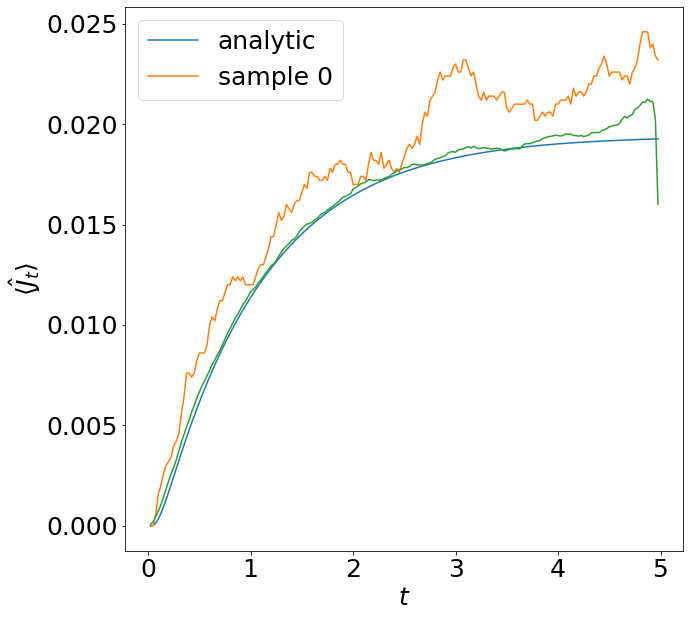

In [ ]:
print((Jtest2_mean))
fig = plt.figure(figsize=(10, 10))


plt.plot(time, J_mean_an, label="analytic")
for i in range(1):
    plt.plot(time, J_mean_emp[i], label="sample %d" %i)
plt.plot(time, Jtest2_mean)
#plt.fill_between(time, Jtest2_mean-Jtest2_var, Jtest2_mean+Jtest2_var,
#    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

plt.xlabel(r"$t$")
plt.ylabel(r"$\langle \hat{{J}}_t\rangle$")
plt.legend()

In [37]:
Entropy = []
for t in time:
    Entropy.append( analyt_entropy(L, t, 1000, A))

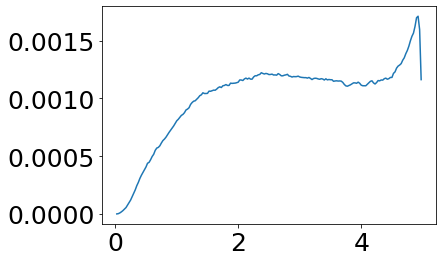

In [40]:
dJmean = (Jtest2_mean[1:] - Jtest2_mean[:-1])/(time[1]-time[0])

plt.plot(time, 2*Jtest2_mean**2 / (Jtest2_var*Entropy))


In [190]:
print(Jtest)

[0.0002, 0.001, 0.0021, 0.0033, 0.004, 0.0052, 0.0063, 0.0072, 0.0077, 0.0081, 0.0086, 0.0094, 0.0097, 0.0105, 0.0105, 0.0108, 0.0112, 0.0112, 0.011, 0.0119, 0.0124, 0.0123, 0.0125, 0.0128, 0.0127, 0.0126, 0.0122, 0.0121, 0.0129, 0.0133, 0.014, 0.0141, 0.0142, 0.0143, 0.014, 0.0142, 0.0141, 0.0142, 0.014, 0.0139, 0.0135, 0.0135, 0.0138, 0.0141, 0.0141, 0.0142, 0.0147, 0.0147, 0.0152, 0.0155, 0.0153, 0.0151, 0.0149, 0.015, 0.015, 0.0151, 0.0155, 0.0157, 0.015, 0.015, 0.0148, 0.0153, 0.0154, 0.0151, 0.0149, 0.0151, 0.0151, 0.015, 0.0144, 0.0143, 0.0146, 0.0149, 0.0153, 0.0155, 0.0155, 0.015, 0.0146, 0.0146, 0.015, 0.0146, 0.015, 0.0155, 0.0152, 0.0157, 0.015, 0.015, 0.0151, 0.0154, 0.0156, 0.0158, 0.0156, 0.0154, 0.0158, 0.0164, 0.0165, 0.0166, 0.0164, 0.0163, 0.0162, 0.0158, 0.0159, 0.0159, 0.0161, 0.0162, 0.0161, 0.0168, 0.0167, 0.0175, 0.0178, 0.0175, 0.0177, 0.0173, 0.0173, 0.0173, 0.0176, 0.0179, 0.0177, 0.0181, 0.0179, 0.0183, 0.018, 0.0186, 0.0187, 0.019, 0.0199, 0.0196, 0.0192, 0

In [116]:
d_matrix = np.array([[0, 1, 0, 1, 1, 0], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])

frame.printMatrix(d_matrix)

J_mean_an1, J_mean_emp1, J_var_emp1, Entropy1, dJ_mean_an1, dJ_mean_emp1, time1 = test_plot(A, L, d_matrix, 5, 10, 200, 1000)

0.00   1.00   0.00   1.00   1.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0
1
2
3
4


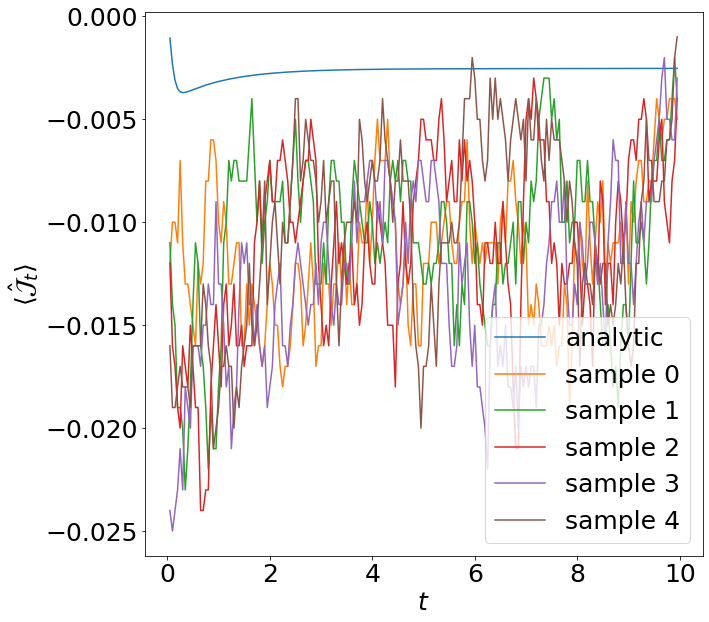

In [117]:
fig = plt.figure(figsize=(10, 10))


plt.plot(time, J_mean_an1, label="analytic")
for i in range(5):
    plt.plot(time, J_mean_emp1[i], label="sample %d" %i)


plt.xlabel(r"$t$")
plt.ylabel(r"$\langle \hat{\mathcal{J}}_t\rangle$")
plt.legend()

In [121]:
d_matrix = np.array([[0, 1, 0, 1, 1, 0], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [-1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])

frame.printMatrix(d_matrix)

J_mean_an2, J_mean_emp2, J_var_emp2, Entropy2, dJ_mean_an2, dJ_mean_emp2, time2 = test_plot(A, L, d_matrix, 5, 10, 200, 200)

0.00   1.00   0.00   1.00   1.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

-1.00   0.00   0.00   0.00   0.00   0.00   

0.00   0.00   0.00   0.00   0.00   0.00   

0
1
2
3
4


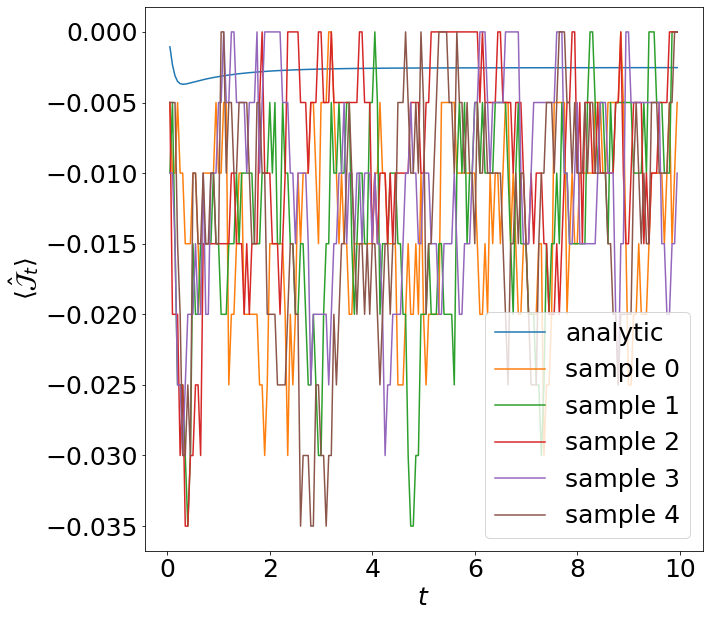

In [122]:
fig = plt.figure(figsize=(10, 10))


plt.plot(time, J_mean_an2, label="analytic")
for i in range(5):
    plt.plot(time, J_mean_emp2[i], label="sample %d" %i)


plt.xlabel(r"$t$")
plt.ylabel(r"$\langle \hat{\mathcal{J}}_t\rangle$")
plt.legend()